In [72]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Data Explanation**  
The following data is on mixed martial arts(MMA) fighters from the UFC. The raw data is collected from Kaggle. I used two Kaggle Data Sets with unique fighter characteristics that I thought would work well to predict a fight outcome. Some features include:
- Fighter Ranking
- Fighter Age
- Fighter Height
- Number of MMA wins
- Number of MMA losses

**Data Science Problem/Solution**  
- The goal of this data science project is to determine if a relationship between fighter characteristics can be used to predict the outcome of a fight. I will create a merged data set based on two data sets found, then I will simulate fights between fighters of the same weight classes. Those fight simulations will generate data that will be stored in a data set with new features generated from differences between the fighters and other features. A winner feature(based on probability) will be in this fight simulation data set and will be used to train a model to make predictions. I will then use another data set from Kaggle that has fight outcomes since the early 2000s, add features to that data set to match the training data and analyze the performance of the models.

In [73]:
file = 'C:\\Users\\kmtaw\\Downloads\\ufc_master_data.csv'
data = pd.read_csv(file)

data.head()

,ranking,name,age,weight,gender,height,ufc_wins,ufc_loses,ufc_draws,ufc_no_contests,mma_wins,mma_loses,mma_draws,mma_no_contests
0,C,Brandon Moreno,27,125,Male,67,8,2,2.0,NaN,19.0,5.0,2.0,NaN
1,1,Deiveson Figueiredo,33,125,Male,65,9,2,1.0,NaN,20.0,2.0,1.0,NaN
2,2,Askar Askarov,29,125,Male,65,3,0,1.0,NaN,14.0,0.0,1.0,NaN
3,3,Alexandre Pantoja,31,125,Male,65,8,3,NaN,NaN,24.0,5.0,NaN,NaN
4,4,Alex Perez,29,125,Male,64,6,2,NaN,NaN,24.0,6.0,NaN,NaN


**Data Cleaning and Exploration**
- Fixing feature presentability, spelling errors, grammar, and punctuation
- Added a Total Fights feature to show fighter experience as well as to add another feature, win percentage of said fighter
- Adding features based on another data set. I'm adding the reach of the fighter, the stance in which they fight, the reach of the fighter, the strikes the fighter lands per minute(on average), and the the average number of takedown the fighter gets. I then use that added data to determine the fighting style of the fighter. If there takedown average is higher than 2.3, they're classifed as a wrestler, if there strikes landed per minute is greater than 4, then they're classified as a striker, and if there strikes landed per minute is within the range 0 to 3.99 and there takedown average is within the range of 2.29 then they're classified with a balanced fighting style. 

In [74]:
data.fillna(0,inplace=True)

data.columns = [
    "Ranking",
    "Name",
    "Age",
    "Weight",
    "Gender",
    "Height",
    "UFC Wins",
    "UFC Losses",
    "UFC Draws",
    "UFC No Contests",
    "MMA Wins",
    "MMA Losses",
    "MMA Draws",
    "MMA No Contests",
]

data["Total Fights"] = (data["MMA Wins"] + data["MMA Losses"] + data["MMA Draws"] + data["MMA No Contests"])

In [75]:
# Define column names for the fighter stats dataset
columns = [
    "name", "wins", "losses", "height", "weight", "reach", "stance", "age", 
    "SLpM", "sig_str_acc", "SApM", "str_def", "td_avg", "td_acc", "td_def", "sub_avg"
]

# Load the fighter stats dataset
fighter_stats = pd.read_csv('C:\\Users\\kmtaw\\Downloads\\fighter_stats.csv', names=columns)

# Check if the 'data' DataFrame contains a column for names
# Update column names in `data` if necessary
if 'name' in data.columns:
    data.rename(columns={'name': 'Name'}, inplace=True)

# Merge datasets on the `Name` column
merged_data = pd.merge(
    data,
    fighter_stats[['name', 'stance', 'reach', 'SLpM', 'td_avg']].rename(columns={'name': 'Name'}),
    on='Name',
    how='left'  # Keeps all rows from the original dataset
)

# Handle missing values
merged_data.fillna({'stance': 'Unknown', 'reach': 0, 'SLpM': 0, 'td_avg': 0}, inplace=True)

# Rename the specified columns in the dataset
merged_data.rename(columns={
    'stance': 'Stance',
    'reach': 'Reach',
    'SLpM': 'Strikes Landed Per Min',
    'td_avg': 'Takedown Average'
}, inplace=True)

# Preview the merged dataset
merged_data.head()

,Ranking,Name,Age,Weight,Gender,Height,UFC Wins,UFC Losses,UFC Draws,UFC No Contests,MMA Wins,MMA Losses,MMA Draws,MMA No Contests,Total Fights,Stance,Reach,Strikes Landed Per Min,Takedown Average
0,C,Brandon Moreno,27,125,Male,67,8,2,2.0,0.0,19.0,5.0,2.0,0.0,26.0,Orthodox,177.8,3.87,1.74
1,1,Deiveson Figueiredo,33,125,Male,65,9,2,1.0,0.0,20.0,2.0,1.0,0.0,23.0,Orthodox,172.72,3.08,1.65
2,2,Askar Askarov,29,125,Male,65,3,0,1.0,0.0,14.0,0.0,1.0,0.0,15.0,Orthodox,170.18,3.05,2.6
3,3,Alexandre Pantoja,31,125,Male,65,8,3,0.0,0.0,24.0,5.0,0.0,0.0,29.0,Orthodox,170.18,4.32,2.2
4,4,Alex Perez,29,125,Male,64,6,2,0.0,0.0,24.0,6.0,0.0,0.0,30.0,Orthodox,165.1,4.12,2.26


In [76]:
# Ensure the columns are numeric
merged_data['Takedown Average'] = pd.to_numeric(merged_data['Takedown Average'], errors='coerce')
merged_data['Strikes Landed Per Min'] = pd.to_numeric(merged_data['Strikes Landed Per Min'], errors='coerce')

# Fill NaN values explicitly instead of using inplace=True
merged_data['Takedown Average'] = merged_data['Takedown Average'].fillna(0)
merged_data['Strikes Landed Per Min'] = merged_data['Strikes Landed Per Min'].fillna(0)

# Define the conditions for the fighting style classification
conditions = [
    (merged_data['Takedown Average'] > 2.3),  # Wrestler
    (merged_data['Strikes Landed Per Min'] > 4),  # Striker
    (merged_data['Strikes Landed Per Min'] <= 3.99) & (merged_data['Takedown Average'] <= 2.29)  # Balanced
]

# Define the corresponding classifications
choices = ['Wrestler', 'Striker', 'Balanced']

# Create the new Fighting Style column using numpy's select function
merged_data['Fighting Style'] = np.select(conditions, choices, default='Unknown')

# Calculate the Win Percentage
merged_data['Win Percentage'] = (merged_data['MMA Wins'] / merged_data['Total Fights']) * 100

# Explicitly assign the result of fillna back to the column
merged_data['Win Percentage'] = merged_data['Win Percentage'].fillna(0)

# Preview the dataset to confirm the new feature
merged_data.head()


,Ranking,Name,Age,Weight,Gender,Height,UFC Wins,UFC Losses,UFC Draws,UFC No Contests,...,MMA Losses,MMA Draws,MMA No Contests,Total Fights,Stance,Reach,Strikes Landed Per Min,Takedown Average,Fighting Style,Win Percentage
0,C,Brandon Moreno,27,125,Male,67,8,2,2.0,0.0,...,5.0,2.0,0.0,26.0,Orthodox,177.8,3.87,1.74,Balanced,73.076923
1,1,Deiveson Figueiredo,33,125,Male,65,9,2,1.0,0.0,...,2.0,1.0,0.0,23.0,Orthodox,172.72,3.08,1.65,Balanced,86.956522
2,2,Askar Askarov,29,125,Male,65,3,0,1.0,0.0,...,0.0,1.0,0.0,15.0,Orthodox,170.18,3.05,2.60,Wrestler,93.333333
3,3,Alexandre Pantoja,31,125,Male,65,8,3,0.0,0.0,...,5.0,0.0,0.0,29.0,Orthodox,170.18,4.32,2.20,Striker,82.758621
4,4,Alex Perez,29,125,Male,64,6,2,0.0,0.0,...,6.0,0.0,0.0,30.0,Orthodox,165.1,4.12,2.26,Striker,80.000000


**More Data Exploration: Visualizations**
- Attempting to identify relationships between features 

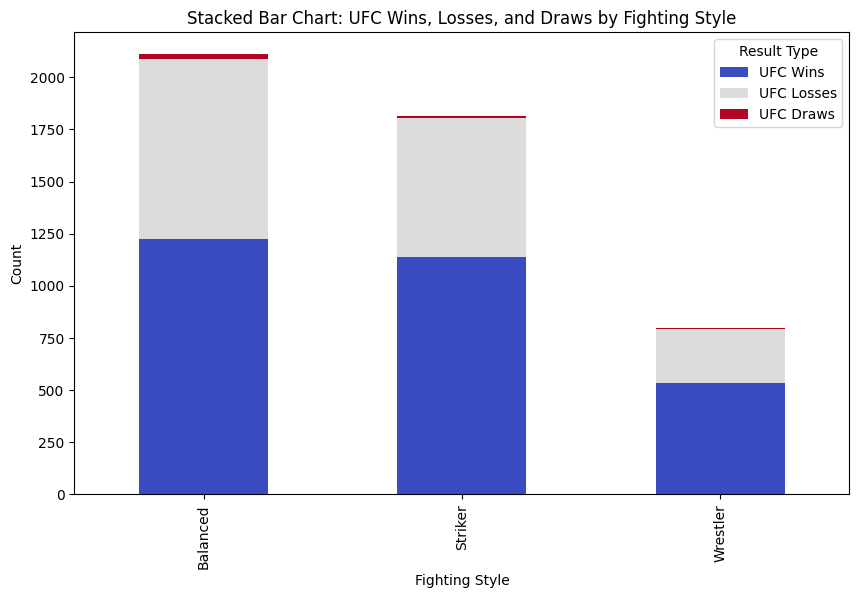

In [77]:
stacked_data = merged_data.groupby('Fighting Style')[['UFC Wins', 'UFC Losses', 'UFC Draws']].sum()
stacked_data.plot(kind='bar', stacked=True, cmap='coolwarm', figsize=(10, 6))
plt.title("Stacked Bar Chart: UFC Wins, Losses, and Draws by Fighting Style")
plt.xlabel("Fighting Style")
plt.ylabel("Count")
plt.legend(title="Result Type")
plt.show()

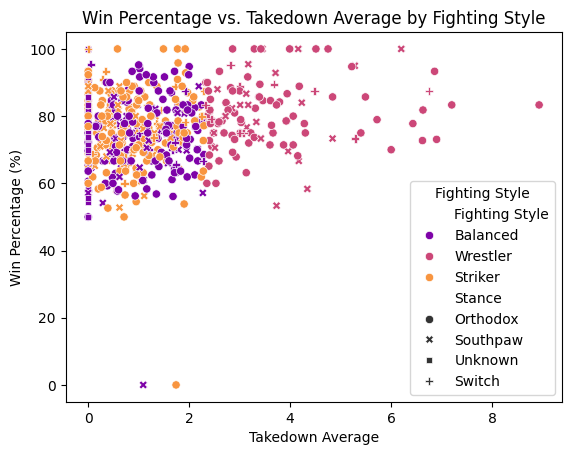

In [78]:
plt.figure()
sns.scatterplot(data=merged_data, x="Takedown Average", y="Win Percentage", hue="Fighting Style", style="Stance", palette="plasma")
plt.title("Win Percentage vs. Takedown Average by Fighting Style")
plt.xlabel("Takedown Average")
plt.ylabel("Win Percentage (%)")
plt.legend(title="Fighting Style")
plt.show()

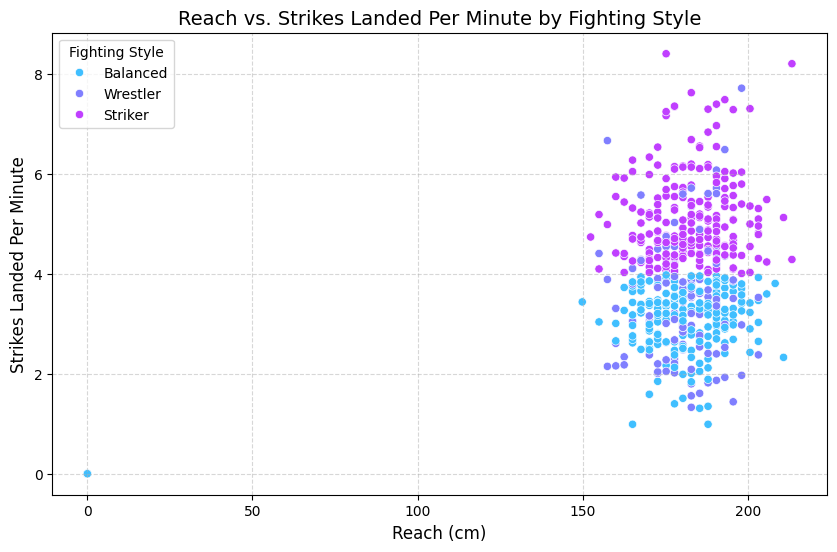

In [79]:
# 2. Visualization: Relationship Between Reach and Strikes Landed Per Minute
# Ensure numeric data for 'Reach' and 'Strikes Landed Per Min'
merged_data['Reach'] = pd.to_numeric(merged_data['Reach'], errors='coerce')
merged_data['Strikes Landed Per Min'] = pd.to_numeric(merged_data['Strikes Landed Per Min'], errors='coerce')

# Drop rows with missing or invalid values
merged_data = merged_data.dropna(subset=['Reach', 'Strikes Landed Per Min', 'Takedown Average'])

# Visualization: Relationship Between Reach and Strikes Landed Per Minute
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data, 
    x="Reach", 
    y="Strikes Landed Per Min", 
    hue="Fighting Style", 
    sizes=(50, 200), 
    palette="cool"
)
plt.title("Reach vs. Strikes Landed Per Minute by Fighting Style", fontsize=14)
plt.xlabel("Reach (cm)", fontsize=12)
plt.ylabel("Strikes Landed Per Minute", fontsize=12)
plt.legend(title="Fighting Style")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

C:\Users\kmtaw\AppData\Local\Temp\ipykernel_23500\3837556453.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


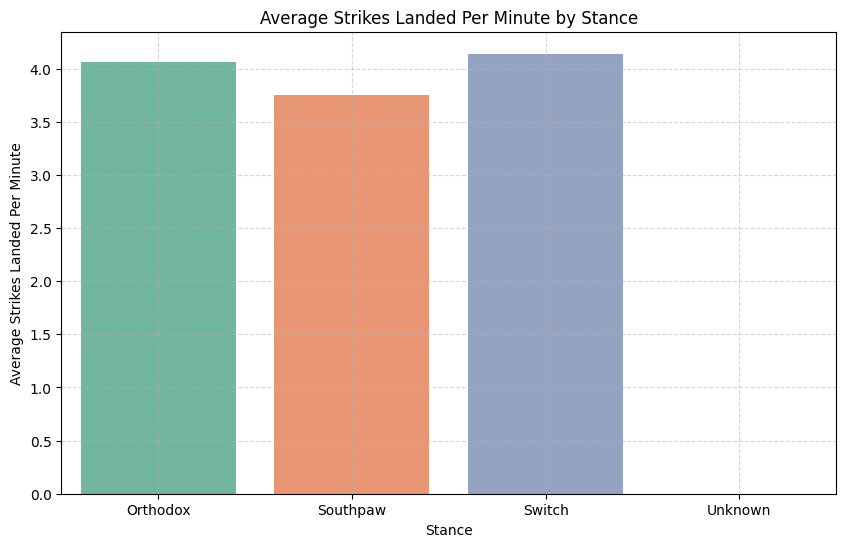

In [80]:
stance_avg_slpm = merged_data.groupby("Stance")["Strikes Landed Per Min"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stance_avg_slpm,
    x="Stance",
    y="Strikes Landed Per Min",
    palette="Set2"
)
plt.title("Average Strikes Landed Per Minute by Stance")
plt.xlabel("Stance")
plt.ylabel("Average Strikes Landed Per Minute")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

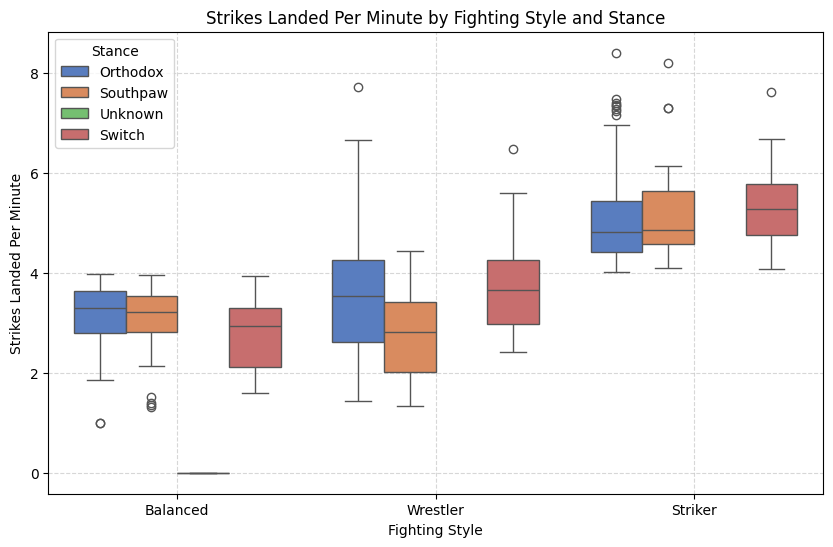

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merged_data,
    x="Fighting Style",
    y="Strikes Landed Per Min",
    hue="Stance",
    palette="muted"
)
plt.title("Strikes Landed Per Minute by Fighting Style and Stance")
plt.xlabel("Fighting Style")
plt.ylabel("Strikes Landed Per Minute")
plt.legend(title="Stance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Generating Simulated Fights with the Merged data**
- Simulated Winning Probabilities: These are used to simulate fight outcomes during data generation for training. For example:
If Fighter A has a 70% winning probability, the training data might label Fighter A as the winner with a 70% chance.
This randomness ensures variability in the simulated outcomes and helps the model generalize better.
- Winning probabilities do not exist in the testing data because the Winner is determined by real-world outcomes, not simulation.
The model should only rely on the same features (Age Difference, Reach Difference, etc.) to predict the Winner.
- Male fighters only fight male fighters, and same for females
- Differences between fighter features are calculated(like reach for example)
- These differences features are allocated weights and are used to calculate the probabilties of a fighter winning

In [82]:
import itertools
import pandas as pd
import numpy as np

# Assuming 'fighters' is your dataset with fighter stats
fighters = merged_data.copy()

# Generate all possible pairwise combinations of fighters within the same weight class
matchup_data = []
for weight_class in fighters['Weight'].unique():
    # Filter fighters by weight class
    weight_class_fighters = fighters[fighters['Weight'] == weight_class]

    # Separate male and female fighters
    male_fighters = weight_class_fighters[weight_class_fighters['Gender'] == 'Male']
    female_fighters = weight_class_fighters[weight_class_fighters['Gender'] == 'Female']

    def simulate_fight(fighter_a_data, fighter_b_data):
        """Simulate the outcome of a fight probabilistically."""
        # Feature differences
        reach_diff = fighter_a_data['Reach'] - fighter_b_data['Reach']
        striking_diff = fighter_a_data['Strikes Landed Per Min'] - fighter_b_data['Strikes Landed Per Min']
        takedown_diff = fighter_a_data['Takedown Average'] - fighter_b_data['Takedown Average']
        win_percentage_diff = fighter_a_data['Win Percentage'] - fighter_b_data['Win Percentage']
        ufc_wins_diff = fighter_a_data['UFC Wins'] - fighter_b_data['UFC Wins']
        total_fights_diff = fighter_a_data['Total Fights'] - fighter_b_data['Total Fights']

        # Consider champion status
        is_champion_a = pd.isna(fighter_a_data['Ranking'])
        is_champion_b = pd.isna(fighter_b_data['Ranking'])

        # Calculate probabilities (weights can be adjusted)
        prob_a = (
            0.2 * (reach_diff > 0) +
            0.2 * (striking_diff > 0) +
            0.1 * (takedown_diff > 0) +
            0.1 * (win_percentage_diff > 0) +
            0.2 * (ufc_wins_diff > 0) +
            0.2 * (total_fights_diff > 0)
        )
        prob_a += 0.1 if is_champion_a else 0
        prob_a -= 0.1 if is_champion_b else 0
        prob_a = np.clip(prob_a, 0.1, 0.9)  # Ensure probabilities stay between 0.1 and 0.9

        # Randomly determine the winner based on probabilities
        winner = fighter_a_data['Name'] if np.random.rand() < prob_a else fighter_b_data['Name']
        return winner, prob_a

    # Generate pairwise matchups for males
    male_matchups = list(itertools.combinations(male_fighters['Name'], 2))
    for fighter_a, fighter_b in male_matchups:
        fighter_a_data = male_fighters[male_fighters['Name'] == fighter_a].iloc[0]
        fighter_b_data = male_fighters[male_fighters['Name'] == fighter_b].iloc[0]

        # Simulate fight outcome
        winner, prob_a = simulate_fight(fighter_a_data, fighter_b_data)

        matchup_data.append({
            'Fighter A': fighter_a,
            'Fighter B': fighter_b,
            'Age Difference': fighter_a_data['Age'] - fighter_b_data['Age'],
            'Reach Difference': fighter_a_data['Reach'] - fighter_b_data['Reach'],
            'Height Difference': fighter_a_data['Height'] - fighter_b_data['Height'],
            'Striking Difference': fighter_a_data['Strikes Landed Per Min'] - fighter_b_data['Strikes Landed Per Min'],
            'Takedown Difference': fighter_a_data['Takedown Average'] - fighter_b_data['Takedown Average'],
            'UFC Wins A': fighter_a_data['UFC Wins'],
            'UFC Wins B': fighter_b_data['UFC Wins'],
            'Total Fights A': fighter_a_data['Total Fights'],
            'Total Fights B': fighter_b_data['Total Fights'],
            'Stance A': fighter_a_data['Stance'],
            'Stance B': fighter_b_data['Stance'],
            'Win Percentage A': fighter_a_data['Win Percentage'],
            'Win Percentage B': fighter_b_data['Win Percentage'],
            'Fighting Style A': fighter_a_data['Fighting Style'],
            'Fighting Style B': fighter_b_data['Fighting Style'],
            'Winner': f"Fighter A: {fighter_a}" if winner == fighter_a else f"Fighter B: {fighter_b}",
            'Winning Probability A': prob_a,
            'Winning Probability B': 1 - prob_a
        })

    # Generate pairwise matchups for females
    female_matchups = list(itertools.combinations(female_fighters['Name'], 2))
    for fighter_a, fighter_b in female_matchups:
        fighter_a_data = female_fighters[female_fighters['Name'] == fighter_a].iloc[0]
        fighter_b_data = female_fighters[female_fighters['Name'] == fighter_b].iloc[0]

        # Simulate fight outcome
        winner, prob_a = simulate_fight(fighter_a_data, fighter_b_data)

        matchup_data.append({
            'Fighter A': fighter_a,
            'Fighter B': fighter_b,
            'Age Difference': fighter_a_data['Age'] - fighter_b_data['Age'],
            'Reach Difference': fighter_a_data['Reach'] - fighter_b_data['Reach'],
            'Height Difference': fighter_a_data['Height'] - fighter_b_data['Height'],
            'Striking Difference': fighter_a_data['Strikes Landed Per Min'] - fighter_b_data['Strikes Landed Per Min'],
            'Takedown Difference': fighter_a_data['Takedown Average'] - fighter_b_data['Takedown Average'],
            'UFC Wins A': fighter_a_data['UFC Wins'],
            'UFC Wins B': fighter_b_data['UFC Wins'],
            'Total Fights A': fighter_a_data['Total Fights'],
            'Total Fights B': fighter_b_data['Total Fights'],
            'Stance A': fighter_a_data['Stance'],
            'Stance B': fighter_b_data['Stance'],
            'Win Percentage A': fighter_a_data['Win Percentage'],
            'Win Percentage B': fighter_b_data['Win Percentage'],
            'Fighting Style A': fighter_a_data['Fighting Style'],
            'Fighting Style B': fighter_b_data['Fighting Style'],
            'Winner': f"Fighter A: {fighter_a}" if winner == fighter_a else f"Fighter B: {fighter_b}",
            'Winning Probability A': prob_a,
            'Winning Probability B': 1 - prob_a
        })

# Convert the matchup data into a DataFrame
matchup_df = pd.DataFrame(matchup_data)

# Drop rows with any NaN values
matchup_df.dropna(inplace=True)

# Preview the simulated matchup dataset
matchup_df.head()


,Fighter A,Fighter B,Age Difference,Reach Difference,Height Difference,Striking Difference,Takedown Difference,UFC Wins A,UFC Wins B,Total Fights A,Total Fights B,Stance A,Stance B,Win Percentage A,Win Percentage B,Fighting Style A,Fighting Style B,Winner,Winning Probability A,Winning Probability B
0,Brandon Moreno,Deiveson Figueiredo,-6,5.08,2,0.79,0.09,8,9,26.0,23.0,Orthodox,Orthodox,73.076923,86.956522,Balanced,Balanced,Fighter A: Brandon Moreno,0.7,0.3
1,Brandon Moreno,Askar Askarov,-2,7.62,2,0.82,-0.86,8,3,26.0,15.0,Orthodox,Orthodox,73.076923,93.333333,Balanced,Wrestler,Fighter B: Askar Askarov,0.8,0.2
2,Brandon Moreno,Alexandre Pantoja,-4,7.62,2,-0.45,-0.46,8,8,26.0,29.0,Orthodox,Orthodox,73.076923,82.758621,Balanced,Striker,Fighter B: Alexandre Pantoja,0.2,0.8
3,Brandon Moreno,Alex Perez,-2,12.70,3,-0.25,-0.52,8,6,26.0,30.0,Orthodox,Orthodox,73.076923,80.000000,Balanced,Striker,Fighter A: Brandon Moreno,0.4,0.6
4,Brandon Moreno,Brandon Royval,-2,5.08,0,-0.46,1.27,8,2,26.0,18.0,Orthodox,Southpaw,73.076923,66.666667,Balanced,Striker,Fighter A: Brandon Moreno,0.8,0.2


**Training Models**  
- The model's role is to predict the winner based on the features of both fighters.
- Winning probabilities are a tool for generating training data—they are not part of the features or the model itself. You will notice I exclude them from the testing data
- For testing, the model predicts winners using features only, and its predictions are evaluated against actual real-world results.
- Models used are KNN, Logistic Regression, and Decision Trees. I've also included hyperparamter tuning and model optimization

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preprocess the data
X = matchup_df.drop(columns=['Winner'])
y = matchup_df['Winner']

# Encode categorical variables and target variable
X = pd.get_dummies(X, drop_first=True)
y = y.map(lambda x: 0 if 'Fighter A' in x else 1)  # Binary encoding for target variable

# Ensure there are no NaN values in X or y
assert not X.isnull().values.any(), "Features contain NaN values"
assert not y.isnull().values.any(), "Target variable contains NaN values"

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Decision Tree
decision_tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search for Decision Tree
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), decision_tree_params, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

# Best parameters and model for Decision Tree
best_dt_model = dt_grid_search.best_estimator_
print("Best Decision Tree Parameters:", dt_grid_search.best_params_)

# Evaluate the optimized Decision Tree model
y_pred_dt = best_dt_model.predict(X_test)
print("Optimized Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Define hyperparameter grid for Logistic Regression
logistic_regression_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Perform grid search for Logistic Regression
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42), logistic_regression_params, cv=5, scoring='accuracy')
lr_grid_search.fit(X_train, y_train)

# Best parameters and model for Logistic Regression
best_lr_model = lr_grid_search.best_estimator_
print("Best Logistic Regression Parameters:", lr_grid_search.best_params_)

# Evaluate the optimized Logistic Regression model
y_pred_lr = best_lr_model.predict(X_test)
print("Optimized Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Define hyperparameter grid for K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform grid search for K-Nearest Neighbors
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

# Best parameters and model for K-Nearest Neighbors
best_knn_model = knn_grid_search.best_estimator_
print("Best K-Nearest Neighbors Parameters:", knn_grid_search.best_params_)

# Evaluate the optimized K-Nearest Neighbors model
y_pred_knn = best_knn_model.predict(X_test)
print("Optimized K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Combine results for easy comparison
results = {
    "Decision Tree": classification_report(y_test, y_pred_dt, output_dict=True),
    "Logistic Regression": classification_report(y_test, y_pred_lr, output_dict=True),
    "K-Nearest Neighbors": classification_report(y_test, y_pred_knn, output_dict=True)
}

# Output the results in a structured format for analysis
for model, result in results.items():
    print(f"\n{model} Results")
    for metric, scores in result.items():
        if isinstance(scores, dict):
            print(f"{metric}: Precision={scores['precision']:.2f}, Recall={scores['recall']:.2f}, F1-Score={scores['f1-score']:.2f}")
        else:
            print(f"{metric}: {scores:.2f}")


Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2212
           1       0.64      0.65      0.65      1593

    accuracy                           0.70      3805
   macro avg       0.69      0.69      0.69      3805
weighted avg       0.70      0.70      0.70      3805

Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Optimized Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2212
           1       0.66      0.59      0.62      1593

    accuracy                           0.70      3805
   macro avg       0.69      0.69      0.69      3805
weighted avg       0.70      0.70      0.70      3805



**Preprocessing The Real World(Testing) Data**  
- Merging the test data to include features from the training data on each fighter

In [ ]:
file_path = 'C:\\Users\\kmtaw\\Downloads\\ufc-master.csv'
real_world_data = pd.read_csv(file_path)

# Select only the required columns
actual_fights = real_world_data[['RedFighter', 'BlueFighter', 'Winner']].rename(
    columns={
        'RedFighter': 'Fighter A',
        'BlueFighter': 'Fighter B'
    }
)
    
# Replace Winner values
actual_fights['Winner'] = actual_fights['Winner'].replace({
    'Red': 'Fighter A',
    'Blue': 'Fighter B'
})

print(actual_fights.head())


In [ ]:
# Ensure merged_data contains all required features
fighter_stats = merged_data.copy()

def enrich_testing_data(actual_fights, fighter_stats):
    enriched_data = []
    for _, row in actual_fights.iterrows():
        # Get fighter stats for both Fighter A and Fighter B
        try:
            fighter_a_stats = fighter_stats[fighter_stats['Name'] == row['Fighter A']].iloc[0]
            fighter_b_stats = fighter_stats[fighter_stats['Name'] == row['Fighter B']].iloc[0]
        except IndexError:
            # Skip if any fighter stats are missing
            continue

        # Combine existing test data features with new features from merged_data
        enriched_data.append({
            'Fighter A': row['Fighter A'],
            'Fighter B': row['Fighter B'],
            'Winner': f"Fighter A: {row['Fighter A']}" if row['Winner'] == 'Fighter A' else f"Fighter B: {row['Fighter B']}",
            # Additional features from merged_data
            'Ranking A': fighter_a_stats['Ranking'],
            'Ranking B': fighter_b_stats['Ranking'],
            'Age Difference': fighter_a_stats['Age'] - fighter_b_stats['Age'],
            'Reach Difference': fighter_a_stats['Reach'] - fighter_b_stats['Reach'],
            'Height Difference': fighter_a_stats['Height'] - fighter_b_stats['Height'],
            'Striking Difference': fighter_a_stats['Strikes Landed Per Min'] - fighter_b_stats['Strikes Landed Per Min'],
            'Takedown Difference': fighter_a_stats['Takedown Average'] - fighter_b_stats['Takedown Average'],
            'UFC Wins A': fighter_a_stats['UFC Wins'],
            'UFC Wins B': fighter_b_stats['UFC Wins'],
            'UFC Losses A': fighter_a_stats['UFC Losses'],
            'UFC Losses B': fighter_b_stats['UFC Losses'],
            'Total Fights A': fighter_a_stats['Total Fights'],
            'Total Fights B': fighter_b_stats['Total Fights'],
            'Win Percentage A': fighter_a_stats['Win Percentage'],
            'Win Percentage B': fighter_b_stats['Win Percentage'],
            'Fighting Style A': fighter_a_stats['Fighting Style'],
            'Fighting Style B': fighter_b_stats['Fighting Style'],
            'Stance A': fighter_a_stats['Stance'],
            'Stance B': fighter_b_stats['Stance']
        })

    # Convert to DataFrame
    enriched_testing_data = pd.DataFrame(enriched_data)

    # Ensure no NaN values in the final dataset
    enriched_testing_data.fillna(0, inplace=True)

    return enriched_testing_data

# Enrich the testing data
enriched_testing_data = enrich_testing_data(actual_fights, merged_data)

# Ensure no NaN values in the final dataset
assert not enriched_testing_data.isnull().values.any(), "Testing data contains NaN values"

# Preview the final enriched testing dataset
enriched_testing_data.head()

**Testing the Data**

In [ ]:
# Ensure the testing data columns match the training data columns
# Add missing columns and ensure the same column order
X_test_real_aligned = enriched_testing_data.drop(columns=['Winner'])

# Encode categorical variables for testing data
X_test_real_aligned = pd.get_dummies(X_test_real_aligned)

# Align columns with training data
X_test_real_aligned = X_test_real_aligned.reindex(columns=X_train.columns, fill_value=0)

# Map Winner column to binary
y_test_real = enriched_testing_data['Winner'].map(lambda x: 0 if 'Fighter A' in x else 1)

# Ensure no NaN values
assert not X_test_real_aligned.isnull().values.any(), "Testing data contains NaN values"
assert not y_test_real.isnull().values.any(), "Testing labels contain NaN values"

# Evaluate Decision Tree model
y_pred_dt_real = best_dt_model.predict(X_test_real_aligned)
print("Decision Tree Classification Report (Testing Data):")
print(classification_report(y_test_real, y_pred_dt_real, zero_division=0))

# Evaluate Logistic Regression model
y_pred_lr_real = best_lr_model.predict(X_test_real_aligned)
print("\nLogistic Regression Classification Report (Testing Data):")
print(classification_report(y_test_real, y_pred_lr_real, zero_division=0))

# Evaluate K-Nearest Neighbors model
y_pred_knn_real = best_knn_model.predict(X_test_real_aligned)
print("\nK-Nearest Neighbors Classification Report (Testing Data):")
print(classification_report(y_test_real, y_pred_knn_real, zero_division=0))

# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fighter A Wins', 'Fighter B Wins'], yticklabels=['Fighter A Wins', 'Fighter B Wins'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test_real, y_pred_dt_real, title="Decision Tree Confusion Matrix")
plot_confusion_matrix(y_test_real, y_pred_lr_real, title="Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test_real, y_pred_knn_real, title="K-Nearest Neighbors Confusion Matrix")

***Model Analysis***  
- Despite hyperparameter tuning, adjusting the test size, and adding more features the models seem to only be able to make predictions accurately about 50% of the time
- The Decision Trees and Logistic Regression models are only predicting Fighter A victories leading to Fighter B victories having precision and recall of 0.
- The K-Nearest Neighbors model is the most balanced model out of the 3 but it's accuracy is only about 50% so it's only just as useful as the other models 
- Both the training data and the testing data required plenty of preprocessing work to include the features and contain relationships I wanted to capture.
- I think the training data also didn't represent the relationship between a fighter's features and outcomes of a particular fight
- The whole concept of trying to predict a fight based on data from each fighter's is a hard task to achieve. Fight outcomes are reliant on an infinite amount of factors. Argueably most of them can't even be measured, so determining a relationship between data and outcomes was a challenge from the beginning
*Ideas for improvements:*
- Adding features to the training data: win streak, average fight duration, etc.
- I probably could have used different models, maybe Neural Networks would have worked well for this sort of data set
- I could have used cross validation to maintain class distributions
  